# Visual Feature for Image Retrieval


In [1]:
import cv2
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import os
import glob
import pickle
from IPython.display import HTML, display

In [2]:
# parameters
NUM_OF_CATEGORY = 35
NUM_OF_RELEVANT = 20

# categories
categories = [c.split('/')[1] for c in glob.glob('data/*')]
categories.sort()

def getCategory(index):
    return categories[index // NUM_OF_RELEVANT]

def getFilename(index):
    category = getCategory(index)
    return category, os.path.join('data', category, category + '_' + str(index % NUM_OF_RELEVANT + 1) + '.jpg')

## Feature Extraction
### Color Similarity
- Grid color moments: 
    
    Slice image into grids, and compute 1st, 2nd, and 3rd moments for each grid in each color channel (RGB color space). 
    <br> The feature is flatten as 225 dimension.

### Texture/Shape Similarity
- Gabor texture:
    
    The Gabor kernel is generated from the OpenCV library. However, the parameters for generating Gabor wavelet ($\sigma$, $\gamma$, and $\lambda$) is compute by myself according to [2]. 
    <br> For the aspect ratio $\gamma$, I found the result calculated from the formula (for computing $\sigma_\nu$) in the original paper [1] is weird (hope it is not because I implemented it wrong.) Therefore, I derived it by myself and the result seems right.
    <br> For the visualization of the Gabor filters, please see the appendix.
    
    The image are first convert to grayscale and convoluted with the Gabor filters. Then, the mean and standard deviation of the results are computed over each grid (similar to grid color moments.)

    Reference:
    - [1] Texture features for browsing and retrieval of image data, https://ieeexplore.ieee.org/document/531803
    - [2] Gabor濾波器詳解, https://www.itread01.com/content/1546890854.html
    

### Local Feature Similarity
- SIFT / ORB
- VLAD

    Reference:
    - [1] OpenCV ORB (Oriented FAST and Rotated BRIEF), https://docs.opencv.org/4.4.0/d1/d89/tutorial_py_orb.html
    - [2] OpenCV Feature Matching, https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
    - [3] Python implementation of VLAD for a CBIR system, https://github.com/jorjasso/VLAD

In [3]:
# Feature extraction
def feature_extraction(name, method, cs='RGB', path='features/', overwrite=False, **kwargs):
    
    # load from files
    filepath = os.path.join(path, name + '.npy')
    if not overwrite and os.path.isfile(filepath):
        print('load from file')
        return np.load(filepath, allow_pickle=True)
    
    features = []
    for category in categories:
        for i in range(1, 21):

            # read image
            filename = os.path.join('data', category, category + '_' + str(i) + '.jpg')
            
            # color space
            img = cv2.imread(filename)
            if cs == 'RGB':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif cs == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cs == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            elif cs == 'GRAY':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # extract feature
            feature = method(img, **kwargs)

            # store feature
            features.append(feature)
            
    # save features into file
    features = np.array(features)
    np.save(filepath, features)
    
    return features
    

In [108]:
# Color similarity
def grid_color_moment(img, gx=5, gy=5):
    # parametrs
    height, width = img.shape[:2]

    # grid color moment
    gcm = []
    for i in range(gx):
        for j in range(gy):
            for k in range(3):
                grid = img[i*height//gx:(i+1)*height//gx, j*width//gy:(j+1)*width//gy, k]

                m1 = np.mean(grid)
                m2 = np.std(grid)
                m3 = np.mean((grid-m1)**3)
                m3 = np.sign(m3) * np.power(np.abs(m3), 1/3)

                gcm.append(m1)
                gcm.append(m2)
                gcm.append(m3)
                
    return gcm

def color_histogram(img, n_bin, gx=1, gy=1):
    # parametrs
    height, width = img.shape[:2]
    
    # quantize factor
#     q = 256 // n_bin
#     total_n_bin = n_bin[0] * n_bin[1] * n_bin[2]
    
    # color
    hists = []
    for i in range(gx):
        for j in range(gy):
            # bins
#             bins = np.zeros(total_n_bin)
            
            grid = img[i*height//gx:(i+1)*height//gx, j*width//gy:(j+1)*width//gy]
            hist = cv2.calcHist([grid], [0, 1, 2], None, n_bin, [0, 256, 0, 256, 0, 256], accumulate=False)
            
#             grid_q = img[i*height//gx:(i+1)*height//gx, j*width//gy:(j+1)*width//gy] // q
#             grid_q = (grid_q[:, :, 0] * n_bin[1] + grid_q[:, :, 1]) * n_bin[2] + grid_q[:, :, 2]
#             for idx in grid_q:
#                 bins[idx] += 1
            
            hists.append(hist)
                    
    # normalization
    hists = np.array(hists)
    hists = hists / np.sum(hists)
    # flatten
    hists = hists.flatten()
                    
    return hists

In [10]:
# Texture/shape similarity
def gabor_texture(img, filters, gx=1, gy=1):
    # parametrs
    height, width = img.shape[:2]
    if gx == -1:
        gx = height
    if gy == -1:
        gy = width

    # Convolution
    feature_vec = []
    for kernel in filters:
        conv = cv2.filter2D(img, -1, kernel)
        
        # chunk into grids
        for i in range(gx):
            for j in range(gy):
                grid = conv[i*height//gx:(i+1)*height//gx, j*width//gy:(j+1)*width//gy]
                # Feature vector
                feature_vec.append(np.mean(grid))
                feature_vec.append(np.std(grid))
    
    return np.array(feature_vec)

def genGaborFilters(ksize=127, K=6, S=4, U_h=0.4, U_l=0.05):

    a = (U_h/U_l)**(1/(S-1))
    # print(a)
    
    # gamma = sigma_x / sigma_y = sigma_v / sigma_u
    sigma_u = ((a-1)*U_h)/((a+1)*np.sqrt(2*np.log(2)))
    #sigma_v = np.tan(np.pi/(2*K))*(U_h-2*np.log(sigma_u**2/U_h))*(2*np.log(2)-((2*np.log(2)*sigma_u)/U_h)**2)**(-1/2)
    sigma_v = np.tan(np.pi/(2*K))*np.sqrt(U_h**2/(2*np.log(2))-sigma_u**2)
    gamma = sigma_v / sigma_u
    
    sigma_base = 1/(2*np.pi*sigma_u)
    # wavelength = 1/freq ?
    lambd_base = 1/U_h
    # print(sigma_u, sigma_v, sigma_base)
    
    filters = []
    
    for m in range(S):
        lambd = lambd_base / a**(-m)
        sigma = sigma_base / a**(-m)
        # print(lambd, sigma, gamma)
        
        for n in range(K):
            theta = n * np.pi / K

            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, cv2.CV_32F)
            filters.append(kernel)
    
    return np.array(filters)


In [6]:
# Local feature similarity
def SIFT(img):
    # make sure the version of opencv-python >= 4.4.0
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    
    return des

def ORB(img):
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
    
    return des

def VLAD(name, des, k, path='features/', overwrite=False):
    '''
        des: local descriptors (# images x # keypoints x d components)
        k: number of visual words
        
    '''
    # load from files
    filepath = os.path.join(path, name + '.npy')
    if not overwrite and os.path.isfile(filepath):
        print('load from file')
        return np.load(filepath, allow_pickle=True)
    
    # load visual words
    vw_filepath = os.path.join(path, name + '_vw.pickle')
    if not overwrite and os.path.isfile(vw_filepath):
        print('load VM from file')
        with open(vw_filepath, 'rb') as fp:
            VWs = pickle.load(fp)
    else:
        # flatten descriptors ( -> (# images x # keypoints) x d components)
        flat_des = list(itertools.chain.from_iterable(des))
        # k-means for visual words
        VWs = KMeans(n_clusters=k, verbose=1).fit(flat_des)
        # save VWs
        with open(vw_filepath, 'wb') as fp:
            pickle.dump(VWs, fp)
    
    # parameters
    d = des[0].shape[1] # d-dimension
    # centroids
    c = VWs.cluster_centers_
    
    VLADs = []
    # for each image
    for X in des:
        # X (# keypoints x d components)
        # get NN(X)
        nn_x = VWs.predict(X.tolist())
        
        # compute VLAD descriptors (D = k x d)
        V = np.zeros((k, d))
        for i in range(k):
            if np.sum(nn_x == i) > 0:
                # sum of difference
                V[i] = np.sum(X[nn_x == i, :] - c[i], axis=0)
                
        # PCA & ADC
        
        # L2 normalization
        V = V / np.linalg.norm(V, ord=2)
        
        VLADs.append(V)
        
    # save features into file
    VLADs = np.array(VLADs)
    np.save(filepath, VLADs)
        
    return VLADs

In [11]:
# Feature Extraction -- Grid Color Moment
# parameters
cs = 'RGB'
grids = 5
name_gcm = 'gcm_g{}_{}'.format(grids, cs)

# extract features
feature_gcm = feature_extraction(name_gcm, grid_color_moment, cs=cs, overwrite=False, gx=grids, gy=grids)
# shape: (grids)^2 * color_channel * 3(mean & std & skewness)
print(feature_gcm.shape)

(700, 225)


In [124]:
# Feature Extraction -- Color Histogram
# parameters
cs = 'RGB'
grids = 5
n_bin = np.array([4, 4, 4])
name_ch = 'ch_g{}_{}_({})'.format(grids, cs, '_'.join(str(x) for x in n_bin))

# extract features
feature_ch = feature_extraction(name_ch, color_histogram, cs=cs, overwrite=True, gx=grids, gy=grids, n_bin=n_bin)
# shape: (grids)^2 * n_bin
print(feature_ch.shape)

(700, 1600)


In [14]:
# Feature Extraction -- Gabor Texture
# parameters
cs = 'GRAY'
grids = 3
K = 6
S = 4
name_gabor = 'gabor_g{}_k{}_s{}_{}'.format(grids, K, S, cs)

# extract features
gabor_filters = genGaborFilters(K=K, S=S)
feature_gabor = feature_extraction(name_gabor, gabor_texture, cs=cs, overwrite=False, filters=gabor_filters, gx=grids, gy=grids)
# shape: K * S * (grids)^2 * 2(mean & std)
print(feature_gabor.shape)

(700, 864)


In [18]:
# Feature Extraction -- SIFT
# parameters
cs = 'RGB'
name_sift = 'sift_{}'.format(cs)

# compute SIFT descriptor
feature_sift = feature_extraction(name_sift, SIFT, overwrite=False)
print(feature_sift.shape)
print(feature_sift[0].shape)

load from file
(700,)
(418, 128)


In [19]:
# Feature Extraction -- ORB
# parameters
cs = 'RGB'
name_orb = 'orb_{}'.format(cs)

# compute ORB descriptor
feature_orb = feature_extraction(name_orb, ORB, overwrite=False)
print(feature_orb.shape)
print(feature_orb[0].shape)

load from file
(700,)
(488, 32)


In [40]:
# Feature Extraction -- VLAD
# parameters
k = 8 # num of VWs
# local descriptor (make sure run the cells above)
des = feature_sift
des_name = name_sift
filename_vlad = 'vlad_k{}_{}'.format(k, des_name)

# compute VLAD descriptor
feature_vlad = VLAD(filename_vlad, des, k, overwrite=True)
print(feature_vlad.shape)

load from file
(700,)
Initialization complete
Iteration 0, inertia 84741017636.0
Iteration 1, inertia 54333081004.46256
Iteration 2, inertia 53390189241.819336
Iteration 3, inertia 53029686414.924835
Iteration 4, inertia 52842767091.25545
Iteration 5, inertia 52743990175.90828
Iteration 6, inertia 52687482143.55609
Iteration 7, inertia 52648372199.764046
Iteration 8, inertia 52617407710.23937
Iteration 9, inertia 52596170109.70297
Iteration 10, inertia 52581087014.96127
Iteration 11, inertia 52569949517.00404
Iteration 12, inertia 52561481821.65718
Iteration 13, inertia 52554589850.45505
Iteration 14, inertia 52548939139.91644
Iteration 15, inertia 52544449621.3168
Iteration 16, inertia 52541163433.18889
Iteration 17, inertia 52538626808.50132
Iteration 18, inertia 52536677811.23079
Iteration 19, inertia 52535142484.842026
Iteration 20, inertia 52533916393.26064
Iteration 21, inertia 52532887433.736824
Iteration 22, inertia 52531991133.03161
Iteration 23, inertia 52531274063.61066
Iter

Iteration 4, inertia 52957209439.92472
Iteration 5, inertia 52928147259.50196
Iteration 6, inertia 52909824741.11433
Iteration 7, inertia 52895164920.846985
Iteration 8, inertia 52881621204.63028
Iteration 9, inertia 52867849507.09456
Iteration 10, inertia 52852408143.60539
Iteration 11, inertia 52834040733.278305
Iteration 12, inertia 52813062530.926636
Iteration 13, inertia 52788830313.858826
Iteration 14, inertia 52761750039.7558
Iteration 15, inertia 52733201332.43202
Iteration 16, inertia 52706755885.89935
Iteration 17, inertia 52684261205.90409
Iteration 18, inertia 52667135762.472275
Iteration 19, inertia 52654581631.230446
Iteration 20, inertia 52645193095.52826
Iteration 21, inertia 52637935134.643074
Iteration 22, inertia 52632167820.08854
Iteration 23, inertia 52627578243.42159
Iteration 24, inertia 52623736741.13529
Iteration 25, inertia 52620474617.876656
Iteration 26, inertia 52617750839.796425
Iteration 27, inertia 52615510209.16352
Iteration 28, inertia 52613590566.9908

Iteration 34, inertia 52495256312.84906
Iteration 35, inertia 52489318279.72155
Iteration 36, inertia 52482231043.784035
Iteration 37, inertia 52473722642.338036
Iteration 38, inertia 52463960934.83294
Iteration 39, inertia 52452894518.06186
Iteration 40, inertia 52441159419.11872
Iteration 41, inertia 52429431050.64438
Iteration 42, inertia 52418399724.52436
Iteration 43, inertia 52408757032.31154
Iteration 44, inertia 52400552603.91186
Iteration 45, inertia 52393928882.77919
Iteration 46, inertia 52389030284.54118
Iteration 47, inertia 52385369732.76883
Iteration 48, inertia 52382550960.469955
Iteration 49, inertia 52380505876.2271
Iteration 50, inertia 52379124937.42922
Iteration 51, inertia 52378165285.95275
Iteration 52, inertia 52377464993.818756
Iteration 53, inertia 52376988167.587326
Iteration 54, inertia 52376620263.94701
Iteration 55, inertia 52376335935.23862
Iteration 56, inertia 52376115872.519196
Iteration 57, inertia 52375959567.39259
Iteration 58, inertia 52375838322.7

Iteration 58, inertia 52372702241.55467
Iteration 59, inertia 52371938737.65892
Iteration 60, inertia 52371403728.78593
Iteration 61, inertia 52371047498.05358
Iteration 62, inertia 52370796131.106926
Iteration 63, inertia 52370625072.41225
Iteration 64, inertia 52370511316.59201
Iteration 65, inertia 52370420420.66163
Iteration 66, inertia 52370350683.73487
Iteration 67, inertia 52370290032.12947
Iteration 68, inertia 52370245667.01478
Iteration 69, inertia 52370211846.71206
Iteration 70, inertia 52370188904.77295
Iteration 71, inertia 52370170301.10309
Converged at iteration 71: center shift 0.10922311570326779 within tolerance 0.1119787846954965.
Initialization complete
Iteration 0, inertia 84664600108.0
Iteration 1, inertia 55554734153.18804
Iteration 2, inertia 54443450139.24041
Iteration 3, inertia 53999559093.32075
Iteration 4, inertia 53618732416.75098
Iteration 5, inertia 53193565974.4883
Iteration 6, inertia 52932942509.930885
Iteration 7, inertia 52810044075.19864
Iteration 

Iteration 36, inertia 52376040533.27056
Iteration 37, inertia 52375828329.61515
Iteration 38, inertia 52375681897.43609
Iteration 39, inertia 52375571639.21612
Iteration 40, inertia 52375491465.47356
Iteration 41, inertia 52375421588.421844
Iteration 42, inertia 52375357298.219734
Iteration 43, inertia 52375298500.00637
Iteration 44, inertia 52375243837.77935
Iteration 45, inertia 52375197342.30175
Iteration 46, inertia 52375158518.2344
Iteration 47, inertia 52375123927.486626
Iteration 48, inertia 52375094489.70281
Iteration 49, inertia 52375070785.12134
Iteration 50, inertia 52375048449.272896
Iteration 51, inertia 52375027332.90663
Iteration 52, inertia 52375007712.52385
Iteration 53, inertia 52374987705.05548
Iteration 54, inertia 52374974865.64395
Converged at iteration 54: center shift 0.07142936682050514 within tolerance 0.1119787846954965.
(700, 8, 128)


In [5]:
# delete loaded features to release memory
# del feature_gcm
# del feature_gabor
# del feature_sift
# del feature_orb
# del feature_vlad

## Evaluations

In [55]:
# Ranking
def ranking(features, dist_func, ascend=True, symmetric=True, **kargs):
    '''
        ascend: ranking in ascending (for distance) or descending order (for similarity)
        symmetric: if the distance function has commutative property, the process can be speedup
    '''
    # distance/similarity
    n_feature = len(features)
    dist = []
    if symmetric:
        for i in range(n_feature):
            dist_row = []
            # reduce reduntant computation
            for j in range(i):
                dist_row.append(dist[j][i])
            # computer features
            for j in range(i, n_feature):
                dist_row.append(dist_func(features[i], features[j], **kargs))
            
            dist.append(dist_row)
    else:
        for i in range(n_feature):
            dist_row = []
            # computer features
            for j in range(n_feature):
                dist_row.append(dist_func(features[i], features[j], **kargs))
            
            dist.append(dist_row)
    
    # ranking (including the target image itself)
    ranked_all = np.argsort(dist, axis=1)
    if not ascend:
        # reverse for descending order
        ranked_all = ranked_all[:, ::-1]
    
    # baseline check: the first retrived image should be the target image itself
    ranked = []
    for i in range(len(ranked_all)):
        target_rank = 0
        if ranked_all[i, 0] != i:
            target_rank = np.where(ranked_all[i] == i)
            print('Baseline check Failed: ', i, ranked_all[i, 0], target_rank)
            
        # remove the target image from the result
        ranked.append(np.delete(ranked_all[i], target_rank))
    
    return np.array(ranked), dist

# distance/similarity function
def Ln_distance(a, b, ord=1, weight=None):
    if weight is not None:
        # weighting over each feature
        return np.linalg.norm((a-b)*weight, ord=ord)
    else:
        return np.linalg.norm(a-b, ord=ord)

# local feature matching function
def matching(query_des, train_des, match_func, k=None, rt=None):
    '''
        k: find best k match of each query descriptor
    '''
    # matching
    matches = match_func(query_des, train_des, k=k)
    
    # ratio test
    good_count = 0
    for m in matches:
        if m[0].distance < rt * m[1].distance:
            # if the distance of best match is much smaller than the second
            # then it is a good match
            good_count += 1
    
    return good_count
    

In [22]:
def computeMAP(ranking):
    # precisiion & recall
    P = []
    R = []
    
    # AP of each image
    APs = []
    
    for i in range(len(ranking)):
        
        tp = 0 # true positive
        fp = 0 # false positive 

        precision = []
        recall = []
        AP = []
        
        cur_category = i // NUM_OF_RELEVANT
        
        for j in range(len(ranking[i])):
            if ranking[i, j] // NUM_OF_RELEVANT == cur_category:
                # matched
                tp += 1
                precision.append(tp / (tp + fp))
                recall.append(tp / NUM_OF_RELEVANT)
                # add precision in to the list
                AP.append(precision[-1])
            else:
                # mismatched
                fp += 1
                precision.append(tp / (tp + fp))
                recall.append(tp / NUM_OF_RELEVANT)
                
        AP = np.mean(AP)
        APs.append(AP)
        P.append(precision)
        R.append(recall)
        
    MMAP = np.mean(APs)
    MAP = [np.mean(APs[i*NUM_OF_RELEVANT:(i+1)*NUM_OF_RELEVANT]) for i in range(NUM_OF_CATEGORY)]
    P = np.mean(P, axis=0)
    R = np.mean(R, axis=0)
    
    return MMAP, MAP, P, R
                
            

In [23]:
# Evaluations
results = {}

In [28]:
# Evaluations -- Grid Color Moment
ranked, dist = ranking(feature_gcm, Ln_distance, ord=1)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_gcm)
print(MMAP)
print(MAP)

results[name_gcm] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

Baseline check Failed:  156 155 (array([1]),)
gcm_g5_RGB
0.1875206822317592
[0.2774617588821415, 0.20474942591782996, 0.11998037290226002, 0.29117687380611285, 0.09950741136620225, 0.15479249614528456, 0.1001535627535985, 0.12813236350310875, 0.19197017506618974, 0.16863368059619804, 0.2132509765853135, 0.1369695806273006, 0.4437758571300681, 0.3680321158443145, 0.08066431503725006, 0.4792106311342703, 0.15735094321698037, 0.07644531075241569, 0.12443282026142484, 0.2710972602533657, 0.3477011226732535, 0.17573541629358097, 0.21306626839475734, 0.08943431897600544, 0.07611971241768366, 0.04141715498779138, 0.169493832620717, 0.16159561586680385, 0.13888449792920435, 0.29090329588856745, 0.16618627151752682, 0.04342506978260679, 0.15607274659314338, 0.15907903820027883, 0.24632158418802166]


In [28]:
# Evaluations -- Grid Color Moment
ranked, dist = ranking(feature_gcm, Ln_distance, ord=1)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_gcm)
print(MMAP)
print(MAP)

results[name_gcm] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

Baseline check Failed:  156 155 (array([1]),)
gcm_g5_RGB
0.1875206822317592
[0.2774617588821415, 0.20474942591782996, 0.11998037290226002, 0.29117687380611285, 0.09950741136620225, 0.15479249614528456, 0.1001535627535985, 0.12813236350310875, 0.19197017506618974, 0.16863368059619804, 0.2132509765853135, 0.1369695806273006, 0.4437758571300681, 0.3680321158443145, 0.08066431503725006, 0.4792106311342703, 0.15735094321698037, 0.07644531075241569, 0.12443282026142484, 0.2710972602533657, 0.3477011226732535, 0.17573541629358097, 0.21306626839475734, 0.08943431897600544, 0.07611971241768366, 0.04141715498779138, 0.169493832620717, 0.16159561586680385, 0.13888449792920435, 0.29090329588856745, 0.16618627151752682, 0.04342506978260679, 0.15607274659314338, 0.15907903820027883, 0.24632158418802166]


In [116]:
# Evaluations -- Color Histgoram
ranked, dist = ranking(feature_ch, Ln_distance, ord=1)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_ch)
print(MMAP)
print(MAP)

results[name_ch] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

Baseline check Failed:  155 156 (array([1]),)
ch_g5_RGB_(4_4_4)
0.21950790273903523
[0.20544822177079283, 0.21799629670037807, 0.1608605402762951, 0.3910188879220536, 0.14225582450574376, 0.24230844330229337, 0.17021014363251405, 0.08633321019613477, 0.19621037781974332, 0.12745611033043416, 0.2956668719373843, 0.16209123123800917, 0.41700032104164186, 0.45899179884022934, 0.14561477213710491, 0.41774702719517987, 0.1550734724336296, 0.11307950905491673, 0.3012712782310886, 0.12268006440126814, 0.29019088885630884, 0.344109156565337, 0.3446509968840511, 0.09036644488549038, 0.12406385771398643, 0.042128653094853814, 0.27408131912874323, 0.166673374289868, 0.3185386916141393, 0.4065869946149694, 0.12149675504486743, 0.055850966381005854, 0.19941862351915016, 0.07202625096651641, 0.3032792193401085]


In [29]:
# Evaluations -- Gabor Texture
weight = 1/np.std(feature_gabor, axis=0)
ranked, dist = ranking(feature_gabor, Ln_distance, ord=1, weight=weight)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_gabor)
print(MMAP)
print(MAP)

results[name_gabor] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

Baseline check Failed:  155 156 (array([1]),)
gabor_g3_k8_s6_GRAY
0.2017774742932
[0.2291059477651804, 0.12086402390356685, 0.09293680196432133, 0.49229384823043115, 0.15580652784810306, 0.121969494563915, 0.19343485558343493, 0.1489757610700179, 0.3417382731284686, 0.21368331953268824, 0.154285011023235, 0.07199054520585699, 0.3692114492903841, 0.3371926574096166, 0.07276881086324193, 0.4720686180951431, 0.08193723066532567, 0.10740065026593308, 0.26119181422997284, 0.17378299617075818, 0.40737837047770886, 0.2558440694136109, 0.20787325403364462, 0.15446540740134668, 0.1144329305188662, 0.12846627043816244, 0.23682862535917598, 0.14614887730499912, 0.10831281286860121, 0.15967414738990193, 0.1959886271519594, 0.08359869313873647, 0.18370189998053682, 0.1490621237571372, 0.31779685421801823]


In [48]:
# Evaluations -- SIFT
matcher = cv2.BFMatcher()
ranked, dist = ranking(feature_sift, matching, ascend=False, symmetric=False, match_func=matcher.knnMatch)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_sift)
print(MMAP)
print(MAP)

results[name_sift] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

sift_RGB
0.30327242803320204
[0.9530478798335504, 0.22475616794975167, 0.08054427207433552, 0.10068727397753555, 0.27180962379565676, 0.15376826412684172, 0.3454232734644897, 0.2153098056879444, 0.3606255218053764, 0.12202047792298305, 0.2710340408973489, 0.10895617271882323, 0.5924277532995248, 1.0, 0.11523986556495654, 0.12401388985553505, 0.7411316710875882, 0.07780682508434641, 1.0, 0.18933100363315367, 0.15159178500073656, 0.4960761958626283, 0.5612256956895645, 0.38910797805181063, 0.11494426796157804, 0.14425983057652716, 0.08236072714638415, 0.22093784383608175, 0.1970175183525203, 0.47328379172894575, 0.17435460424152524, 0.10436887053015453, 0.10696865517160987, 0.12666050056883715, 0.22344293366342552]


In [ ]:
# Evaluations -- ORB
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
ranked, dist = ranking(feature_sift, matching, ascend=False, symmetric=False, match_func=matcher.knnMatch)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_sift)
print(MMAP)
print(MAP)

results[name_sift] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

In [41]:
# Evaluations -- VLAD
ranked, dist = ranking(feature_vlad, Ln_distance, ord=2)

# MAP
MMAP, MAP, P, R = computeMAP(ranked)
print(name_vlad)
print(MMAP)
print(MAP)

results[name_vlad] = {
    'MMAP': MMAP,
    'MAP': MAP,
    'P': P,
    'R': R
}

# display distance
# plt.imshow(dist, 'gray')
# plt.show()

Baseline check Failed:  156 155 (array([1]),)
0.19790298266506356
[0.4355987031713314, 0.42077504656323084, 0.0661014176563666, 0.3025908474309868, 0.1068480920643142, 0.4573097530005839, 0.24329720966369478, 0.32881553440609884, 0.390336746163096, 0.21827128690477254, 0.21574161956808605, 0.05560365789820113, 0.3808291511797008, 0.6824725506293351, 0.04465186691041005, 0.08268172708609677, 0.22801522284581038, 0.17363810072047606, 0.3525100311149142, 0.05004986638225033, 0.06594341647720234, 0.20213264912160372, 0.1551350463347327, 0.05588972932912534, 0.05017329579627496, 0.10989354674740566, 0.13378432083045527, 0.10262240585344913, 0.3092828441116504, 0.0611824374818785, 0.05668038951444394, 0.057027168216920776, 0.07534337463481411, 0.06631826152671597, 0.18905707594079507]


categories vs. methods,MAP,Best Two Categories (w/ MAP),Worst Two Categories (w/ MAP)
gcm_g5_RGB,0.188,"goggles (0.479), garment (0.444)","nba_jersey (0.041), sweeping_robot (0.043)"
gabor_g3_k8_s6_GRAY,0.202,"blue_pillow (0.492), goggles (0.472)","drum (0.072), glasses (0.073)"
sift_RGB,0.303,"korean_snack (1.000), gge_snack (1.000)","ice_cream (0.078), bicycle (0.081)"
gcm_g1_RGB_(4_4_4),0.194,"garment (0.420), blue_pillow (0.382)","nba_jersey (0.043), sweeping_robot (0.046)"
ch_g1_RGB_(4_4_4),0.194,"garment (0.420), blue_pillow (0.382)","nba_jersey (0.043), sweeping_robot (0.046)"
ch_g5_RGB_(4_4_4),0.220,"gge_snack (0.459), goggles (0.418)","nba_jersey (0.042), sweeping_robot (0.056)"


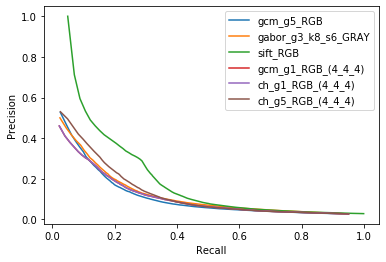

In [117]:
# Comparison between methods
table = """
<table>
<tr>
<th>categories vs. methods</th>
<th>MAP</th>
<th>Best Two Categories (w/ MAP)</th>
<th>Worst Two Categories (w/ MAP)</th>
</tr>
"""
for key in results:
    MAP = results[key]['MAP']
    MAP_sort = np.argsort(MAP)
    # print(MAP_sort)
    
    table += """
    <tr>
    <td>{}</td>
    <td>{:.3f}</td>
    <td>{} ({:.3f}), {} ({:.3f})</td>
    <td>{} ({:.3f}), {} ({:.3f})</td>
    </tr>
    """.format(key, results[key]['MMAP'], categories[MAP_sort[-1]], MAP[MAP_sort[-1]], categories[MAP_sort[-2]], MAP[MAP_sort[-2]], categories[MAP_sort[0]], MAP[MAP_sort[0]], categories[MAP_sort[1]], MAP[MAP_sort[1]])

    # PR curve
    plt.plot(results[key]['R'], results[key]['P'], label=key)

    
table += "</table>"
display(HTML(table))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [27]:
for i, cate in enumerate(categories):
    print(i, cate)

0 aloe_vera_gel
1 baby_shoes
2 bicycle
3 blue_pillow
4 bottle
5 bracelet
6 cartoon_purse
7 chair
8 children_dress
9 clock
10 cup
11 drum
12 garment
13 gge_snack
14 glasses
15 goggles
16 hand_cream
17 ice_cream
18 korean_snack
19 leather_purse
20 lollipop
21 men_clothes
22 minnie_dress
23 minnie_shoes
24 mouse
25 nba_jersey
26 orange
27 overalls
28 skirt
29 sprite
30 suitcase
31 sweeping_robot
32 tennis_ball
33 trousers
34 women_clothes


Target Image: data/bicycle/bicycle_1.jpg


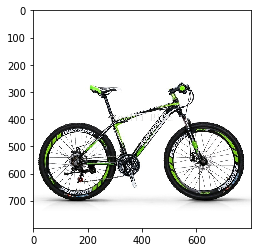

Result Images 0: data/bicycle/bicycle_1.jpg
Result Images 1: data/lollipop/lollipop_8.jpg
Result Images 2: data/trousers/trousers_14.jpg
Result Images 3: data/mouse/mouse_4.jpg
Result Images 4: data/lollipop/lollipop_16.jpg
Result Images 5: data/suitcase/suitcase_14.jpg
Result Images 6: data/drum/drum_3.jpg
Result Images 7: data/clock/clock_4.jpg
Result Images 8: data/overalls/overalls_16.jpg
Result Images 9: data/sprite/sprite_7.jpg
Result Images 10: data/minnie_dress/minnie_dress_1.jpg
Result Images 11: data/tennis_ball/tennis_ball_4.jpg
Result Images 12: data/drum/drum_11.jpg
Result Images 13: data/cup/cup_8.jpg
Result Images 14: data/bottle/bottle_7.jpg
Result Images 15: data/mouse/mouse_9.jpg
Result Images 16: data/lollipop/lollipop_6.jpg
Result Images 17: data/sweeping_robot/sweeping_robot_4.jpg
Result Images 18: data/mouse/mouse_3.jpg


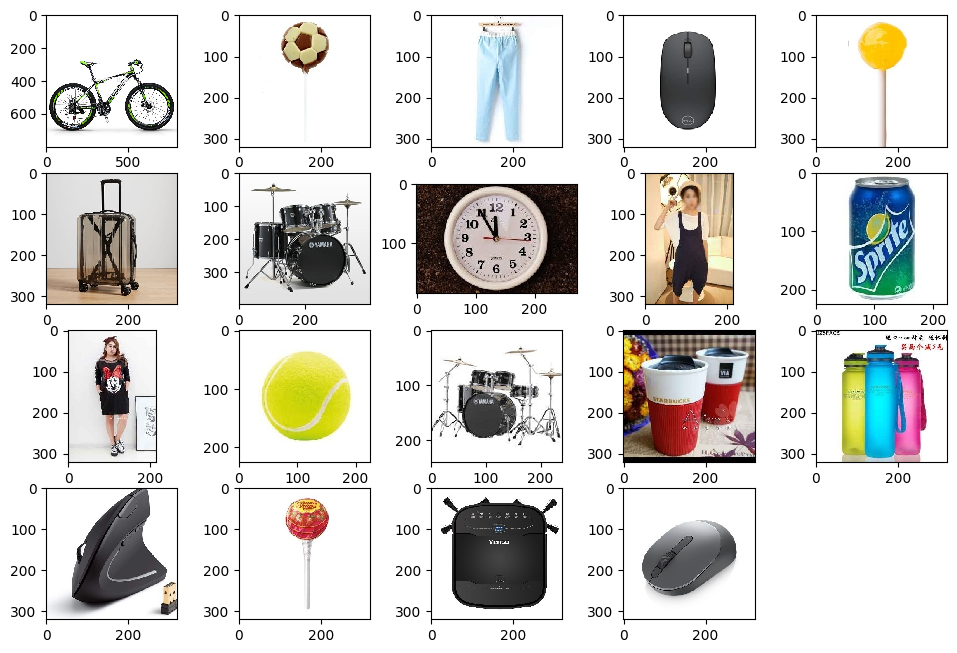

In [76]:
# Visualization
# target image
target_idx = 2*20
cat, filename = getFilename(target_idx)
print('Target Image:', filename)
plt.imshow(Image.open(filename))
plt.show()

# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# queried images
for i in range(19):
    result_idx = ranked[target_idx, i]
    cat, filename = getFilename(result_idx)
    print('Result Images {}: {}'.format(i, filename))
    plt.subplot(4, 5, i+1)
    plt.imshow(Image.open(filename))
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi

# Appendix


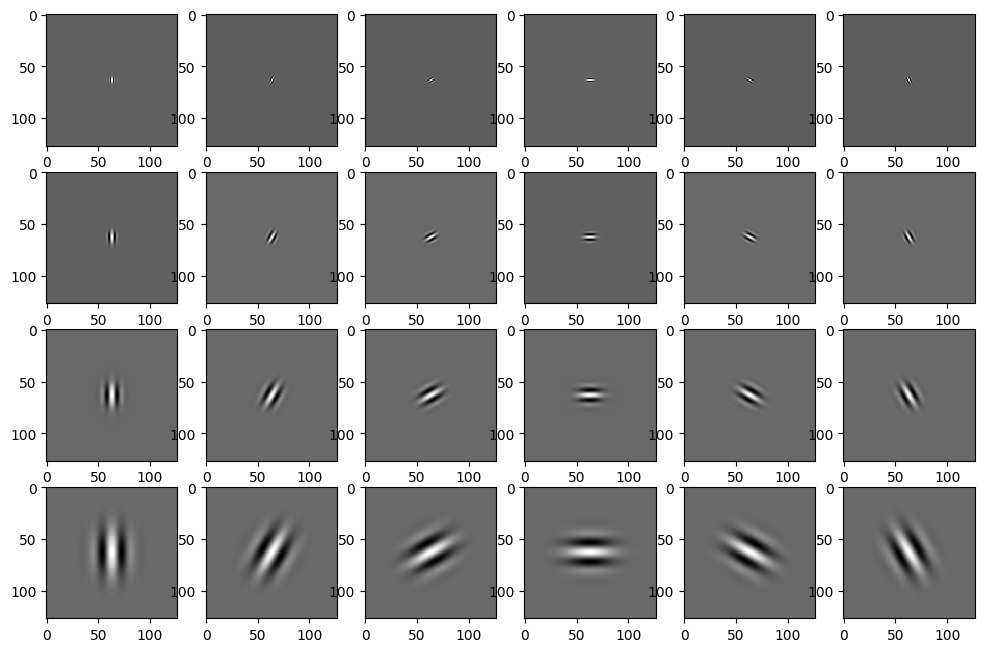

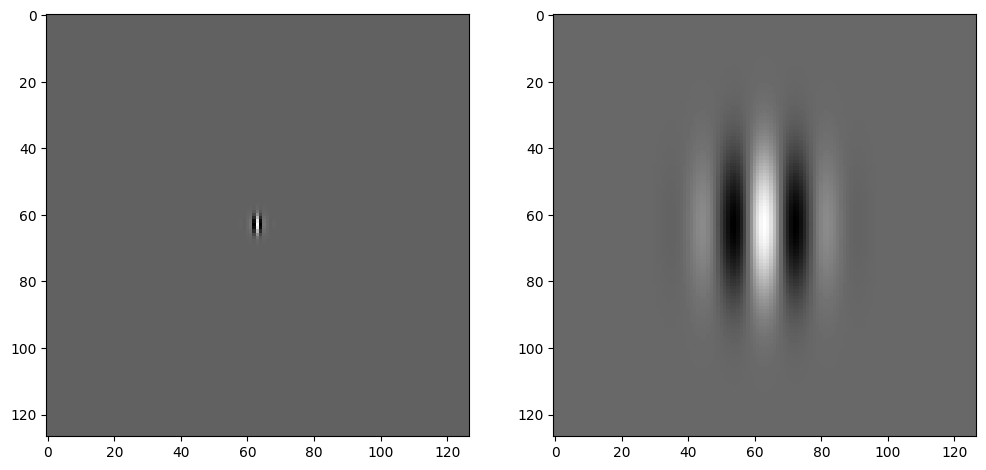

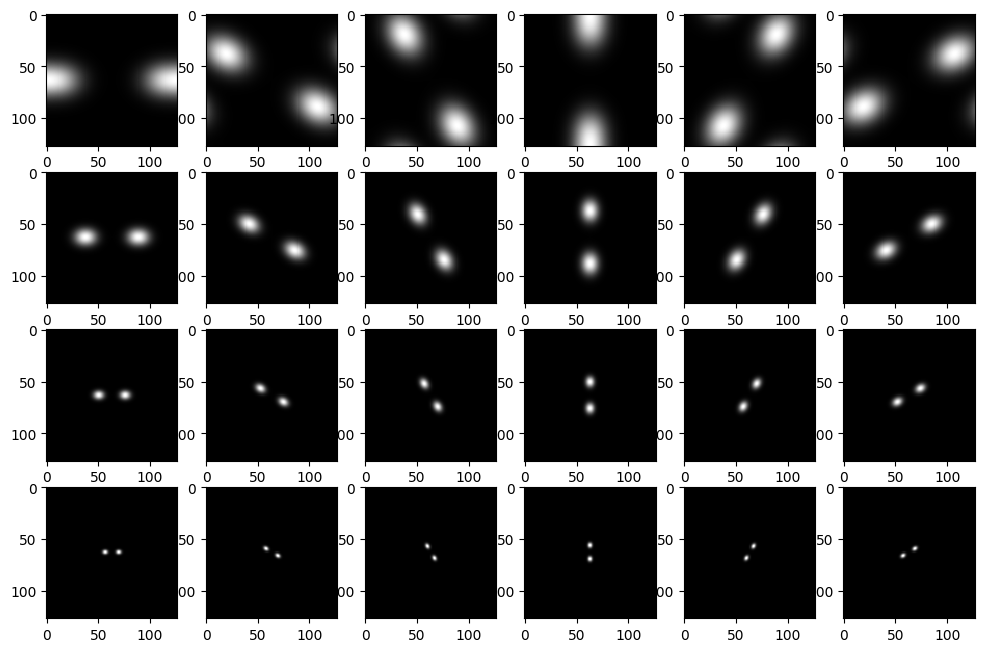

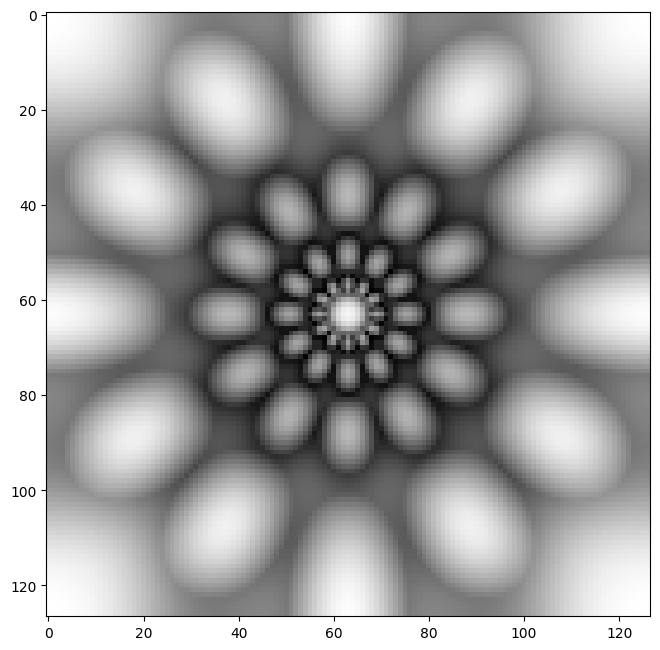

In [17]:
# Visualization Gabor filter
# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# generate filters
K = 6
S = 4
filters = genGaborFilters(K=K, S=S)

# display filters
for i in range(S*K):
    plt.subplot(S, K, i+1)
    plt.imshow(filters[i], 'gray')
plt.show()

# display filters with certain orientation
orientation = 0
plt.subplot(1, 2, 1)
plt.imshow(filters[orientation], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(filters[K*(S-1)+orientation], 'gray')
plt.show()

# display Fourior transform of Gabor filter
half_peaks = None
for i in range(S*K):
    f = np.fft.fft2(filters[i])
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    half_peak = np.abs(mag - np.max(mag)/2)
    if half_peaks is None:
        half_peaks = half_peak/np.max(mag)
    else:
        half_peaks += half_peak/np.max(mag)
    plt.subplot(S, K, i+1)
    plt.imshow(mag, 'gray')
plt.show()

# display half peak
plt.imshow(half_peaks, 'gray')
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi